In [2]:
# IMPORTANT! : Follow this link to see the two maps : 
 # https://nbviewer.org/github/BaptisteLazarus/Python/blob/main/AnalysisVisualization_SelfServiceBikesInParis.ipynb

#Analyzing and maping of "Vélib'" in Paris (self service bikes system) by connecting to the datas in real time and by using folium library.

In [55]:
import pandas

In [56]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline

In [57]:
import requests

In [58]:
import folium

In [59]:
#import of stations informations and store its in a pandas dataframe
url = "https://opendata.paris.fr/api/records/1.0/search/"
dataset = "velib-disponibilite-en-temps-reel"
#get the number of stations
r = requests.get(url = url, params = dict(dataset = dataset)).json()
#get everuthing
df = pandas.DataFrame([s["fields"] for s in requests.get(url = url, params = dict(dataset = dataset, rows = r['nhits'])).json()['records']])
df.head()

,name,stationcode,ebike,mechanical,coordonnees_geo,duedate,numbikesavailable,numdocksavailable,capacity,is_renting,is_installed,nom_arrondissement_communes,is_returning
0,Benjamin Godard - Victor Hugo,16107,2,8,"[48.865983, 2.275725]",2023-01-12T14:31:03+00:00,10,25,35,OUI,OUI,Paris,OUI
1,Toudouze - Clauzel,9020,1,1,"[48.87929591733507, 2.3373600840568547]",2023-01-12T14:30:42+00:00,2,19,21,OUI,OUI,Paris,OUI
2,Saint-Sulpice,6003,1,14,"[48.85165383178419, 2.3308077827095985]",2023-01-12T14:32:45+00:00,15,5,21,OUI,OUI,Paris,OUI
3,Le Brun - Gobelins,13007,3,0,"[48.835092787823875, 2.353468135133752]",2023-01-12T14:32:59+00:00,3,44,48,OUI,OUI,Paris,OUI
4,Lacépède - Monge,5110,6,0,"[48.84389286531899, 2.3519663885235786]",2023-01-12T14:31:39+00:00,6,15,23,OUI,OUI,Paris,OUI


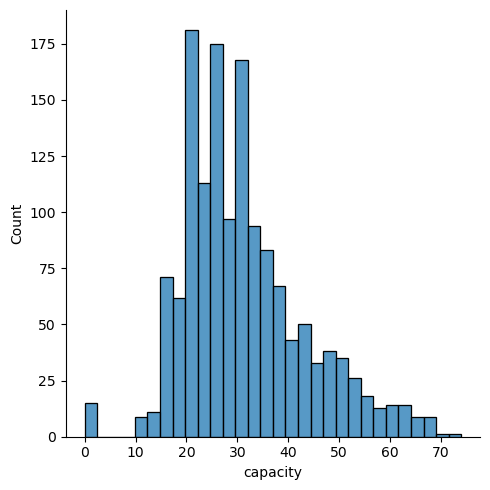

In [60]:
#capacity distribution
seaborn.displot(data = df, x = "capacity")

<AxesSubplot:xlabel='capacity'>

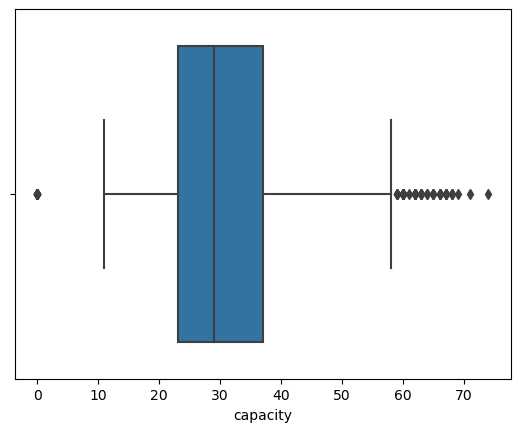

In [61]:
#capacity distribution displayed with boxplot
seaborn.boxplot(data = df, x = "capacity")

<AxesSubplot:xlabel='capacity', ylabel='nom_arrondissement_communes'>

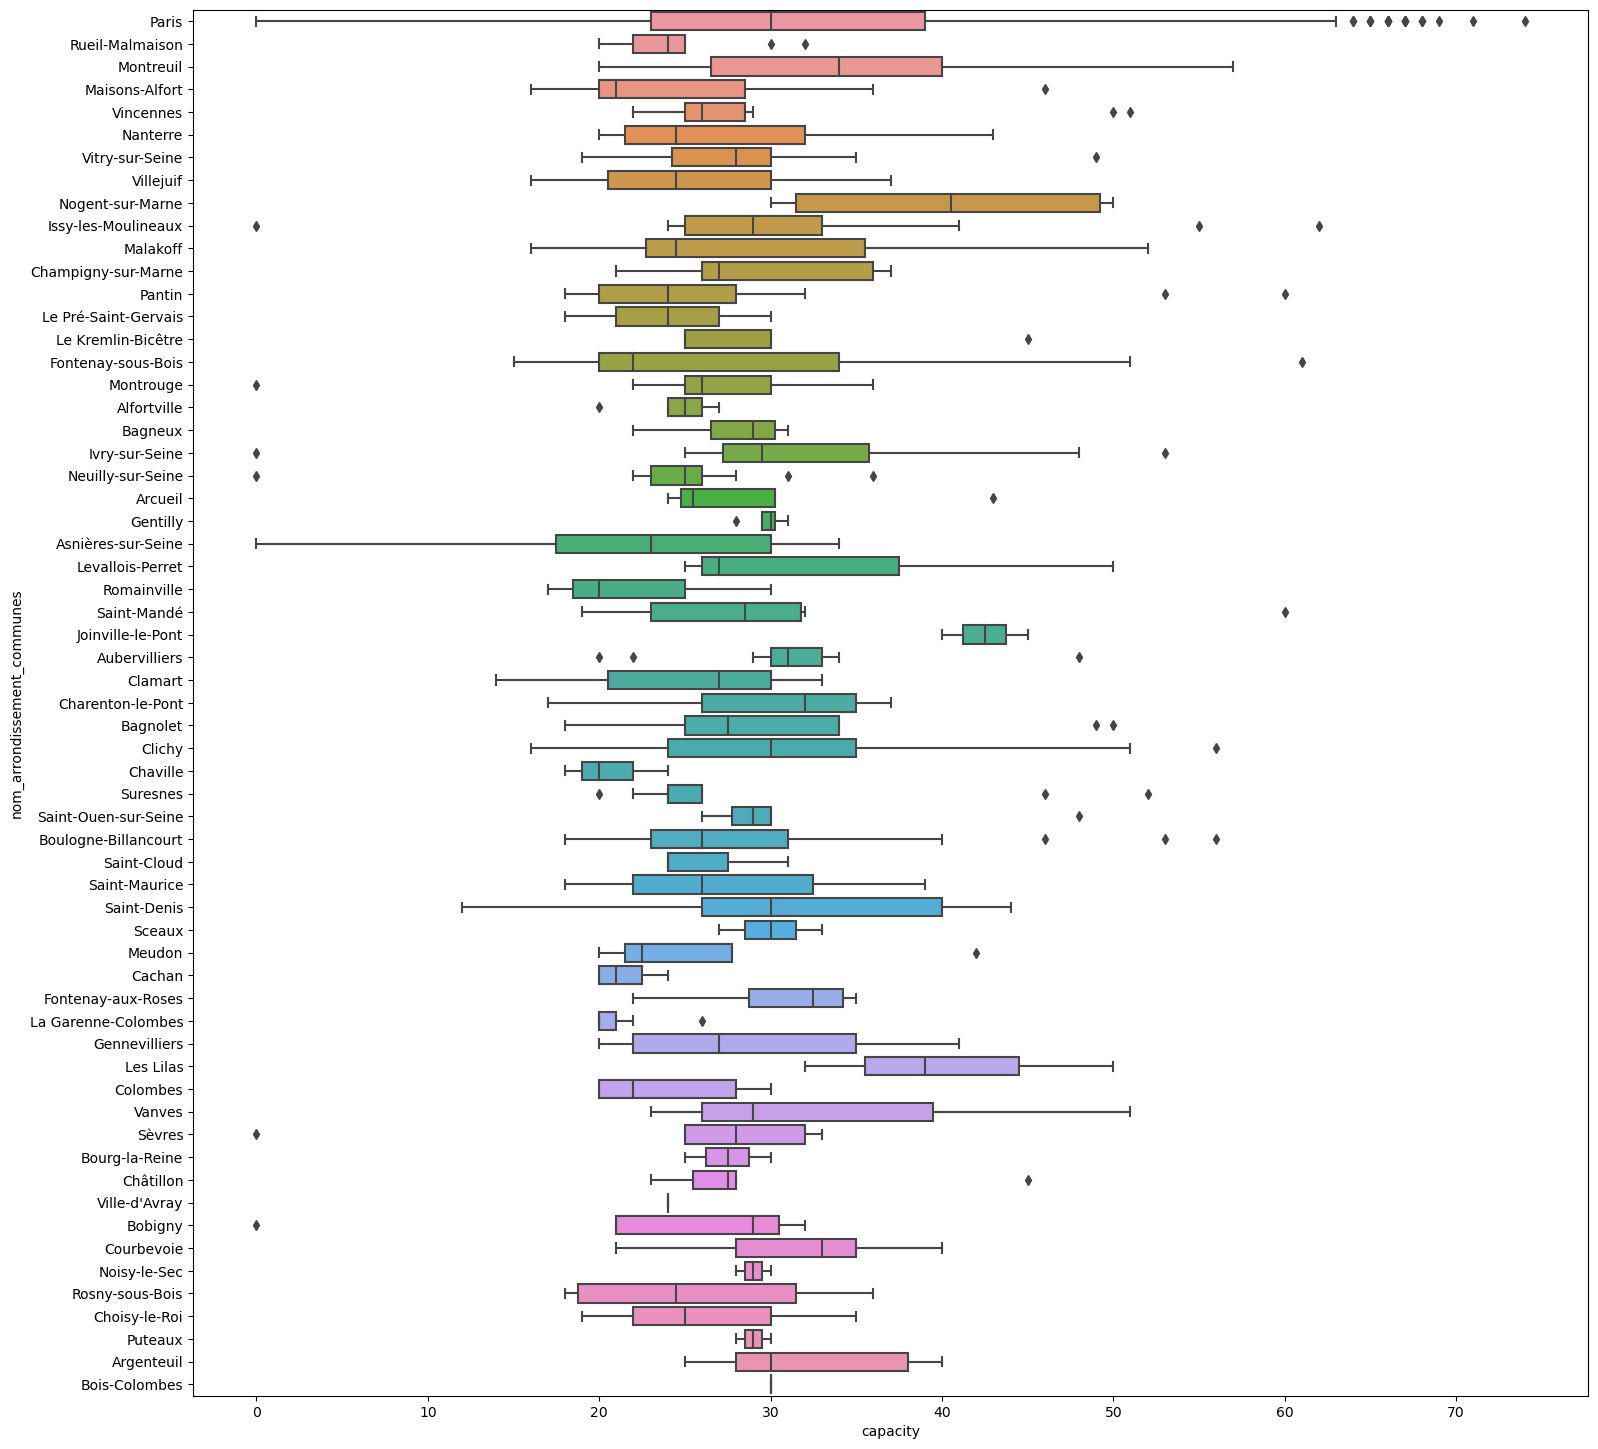

In [62]:
#cities distribution
plt.figure(figsize=(18,18))
seaborn.boxplot(data = df, x = "capacity", y = "nom_arrondissement_communes")

In [63]:
#Display the stations on a map
def popup(station):
    msg = "<strong>" + station["name"] + "</strong>"\
        + " (" + station["nom_arrondissement_communes"] + ")"
    return msg

centre = [48.87, 2.35]
paris = folium.Map(location = centre, zoom_start = 11)

for st in range(df.shape[0]):
    station = df.iloc[st,:]
    # print(popup(station))
    folium.Marker(station["coordonnees_geo"],
                  tooltip = station["name"],
                  popup = popup(station)).add_to(paris)
    
paris

In [64]:
#stations number for each city
ag_count = df.filter(["nom_arrondissement_communes", "capacity"])\
    .groupby("nom_arrondissement_communes")\
    .count()\
    .rename(columns = {"capacity": "NumStations"})
ag_count.head()

,NumStations
nom_arrondissement_communes,
Alfortville,5
Arcueil,4
Argenteuil,5
Asnières-sur-Seine,12
Aubervilliers,13


In [65]:
#capacity number for each city
ag_sum = df.filter(["nom_arrondissement_communes", "capacity", "numbikesavailable", "numdocksavailable"])\
    .groupby("nom_arrondissement_communes")\
    .aggregate(["sum"])\
    .droplevel(level = 1, axis = 1)
ag_sum.head()

,capacity,numbikesavailable,numdocksavailable
nom_arrondissement_communes,,,
Alfortville,122,52,64
Arcueil,118,16,100
Argenteuil,161,85,72
Asnières-sur-Seine,254,106,135
Aubervilliers,404,198,190


In [66]:
#average GPS coordinates (display preparation)
ag_mean = df.filter(["nom_arrondissement_communes"])\
    .assign(lat = [c[0] for c in df["coordonnees_geo"]])\
    .assign(lng = [c[1] for c in df["coordonnees_geo"]])\
    .groupby("nom_arrondissement_communes")\
    .aggregate(["mean"])\
    .droplevel(level = 1, axis = 1)
ag_mean.head()

,lat,lng
nom_arrondissement_communes,,
Alfortville,48.801567,2.422036
Arcueil,48.806420,2.331766
Argenteuil,48.947850,2.239504
Asnières-sur-Seine,48.915342,2.288465
Aubervilliers,48.910740,2.381001


In [67]:
#resume
ag_final = pandas.concat([ag_count, ag_sum, ag_mean], axis = 1)
ag_final.head()

,NumStations,capacity,numbikesavailable,numdocksavailable,lat,lng
nom_arrondissement_communes,,,,,,
Alfortville,5,122,52,64,48.801567,2.422036
Arcueil,4,118,16,100,48.806420,2.331766
Argenteuil,5,161,85,72,48.947850,2.239504
Asnières-sur-Seine,12,254,106,135,48.915342,2.288465
Aubervilliers,13,404,198,190,48.910740,2.381001


In [68]:
#display markers for each city(located in stations center of the city) with belows informations
def popup_city(city):
    msg = "<strong>" + city.name + "</strong><ul>"\
        + "<li>Number of stations : " + str(city["NumStations"]) + "</li>"\
        + "<li>Total Capacity : " + str(city["capacity"]) + "</li>"\
        + "<li>Bikes Available : " + str(city["numbikesavailable"]) + "</li>"\
        + "<li>Docks Available : " + str(city["numdocksavailable"]) + "</li></ul>"
    iframe = folium.IFrame(msg)
    popup = folium.Popup(iframe,
                     min_width = 300,
                     max_width = 300)
    return popup

center = [48.87, 2.35]
map_city = folium.Map(location = center, zoom_start = 11)

for v in range(ag_final.shape[0]): #
    city = ag_final.iloc[v,:]
    folium.Marker([city.lat, city.lng],
                  tooltip = city.name,
                  popup = popup_city(city)).add_to(map_city)
map_city